In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from test_bias import test_bias, train_test_bias
from plotting import plot_bias
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

/Users/ebensen/opt/anaconda3/envs/ai_bias/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv('../data/final_train_data.csv')
print(data.columns)
# Print min and max date
print(data['Date'].min())
print(data['Date'].max())
data['FRC'].value_counts(normalize=True)


Index(['Temp', 'WindSp', 'Precip', 'Snow', 'StationId', 'Date', 'Dir', 'Long',
       'Lat', 'NumberOfLanes', 'FC', 'SpeedLimit', 'FRC', 'DayOfWeek', 'Month',
       'Hour', 'AvgSp', 'ProbeCount', 'Volume', 'PenRate',
       'ProbeCountLastWeek', 'AvgProbeCountLastMonth', 'fold'],
      dtype='object')
2019-01-07
2019-06-13


5    0.373221
6    0.301601
4    0.164702
2    0.120552
3    0.039924
Name: FRC, dtype: float64

# Plot Function

In [3]:
odata = pd.read_csv('../data/binary_bias_fdr.csv')
odata = odata[(odata['Demographic']=='MINRTY_0.6') | (odata['Demographic']=='MINRTY_0.7') | (odata['Demographic']=='MINRTY_0.8') | (odata['Demographic']=='MINRTY_0.9')]
odata['r2_diff'] = abs(odata['r2_1'] - odata['r2_0']) 
data0 = pd.read_csv('../data/test_data_MINRTY_etype_0_opt_gamma.csv')[odata.columns]
plot_data = pd.concat([odata, data0])
plot_data 

,Demographic,r2_0,r2_1,pval,Sig at 0.05,Sig at 0.01,Sig at 0.001,r2_diff
6,MINRTY_0.6,0.918227,0.813637,0.0002,True,True,True,0.104590
21,MINRTY_0.7,0.915285,0.798684,0.0002,True,True,True,0.116602
36,MINRTY_0.8,0.901330,0.684621,0.0000,True,True,True,0.216710
51,MINRTY_0.9,0.899442,0.488900,0.0000,True,True,True,0.410542
0,MINRTY_0.6,0.895427,0.807532,0.0010,True,True,False,0.087895
1,MINRTY_0.7,0.895056,0.790271,0.0001,True,True,True,0.104785
2,MINRTY_0.8,0.882338,0.696909,0.0000,True,True,True,0.185429
3,MINRTY_0.9,0.879925,0.533559,0.0000,True,True,True,0.346366


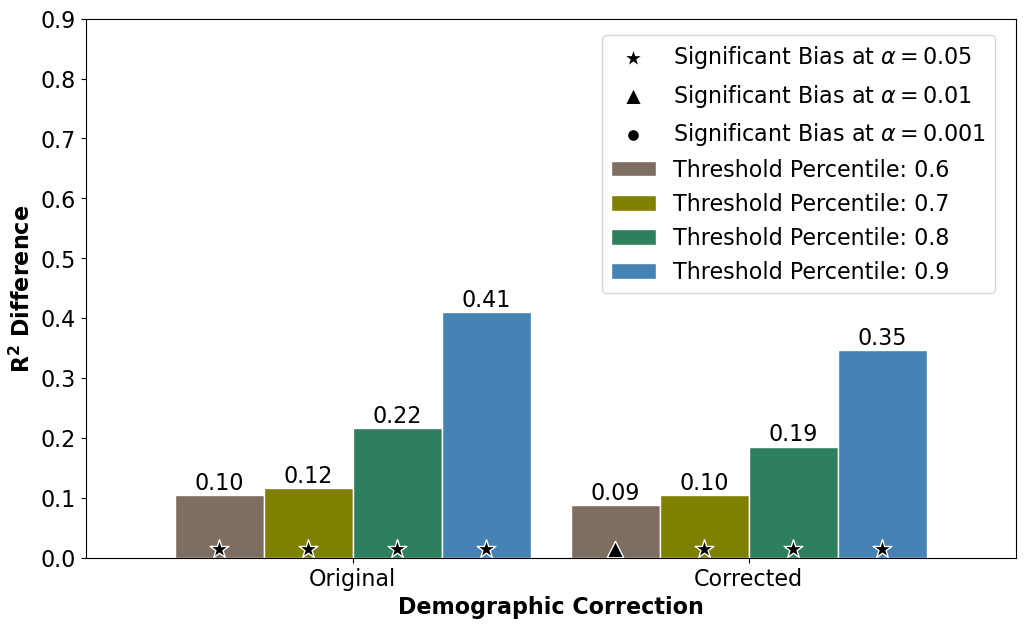

In [4]:
labels = ['Original', 'Corrected']
fig = plot_bias(plot_data, labels)

# Test Bias Function

In [5]:
params = {'colsample': 0.8881316595971249,
 'depth': 8.39625354272183,
 'g': -1.6269034904493944,
 'min_cw': 5.652800886786517,
 'n': 4.817420401698789,
 'p': -1.5962868458248356,
 'subsample': 0.5067325518969111}

In [6]:
from typing import Iterable
def add_demographic_data(data, demo):
    if isinstance(demo, str):
        demo = [demo]
    demos = pd.read_csv('../data/off_freeway_station_demographics.csv')
    cols = ['STN_NUMBER'] +['EPL_' + d for d in demo]
    demos = demos[cols]
    # rename columns
    dct = {'EPL_'+d:d for d in demo}
    demos.rename(columns=dct, inplace=True)
    demos.rename(columns={'STN_NUMBER':'StationId'}, inplace=True)  
    data = pd.merge(data, demos, on='StationId', how='left')
    return data

def to_dmatrix(X, y):
    # get number of columns of np array X
    n_cols = X.shape[1]
    weights = [1.0 for _ in range(n_cols-1)] + [0.0]
    return xgb.DMatrix(X, label=y, feature_weights=weights)

In [7]:
demographic = 'MINRTY'
cols_drop = ['Date', 'FC', 'PenRate', 'NumberOfLanes', 'Dir', 'Lat', 'Long', 'StationId']

raw_data_train = pd.read_csv("../data/final_train_data.csv")
raw_data_test = pd.read_csv("../data/final_test_data.csv")
raw_data_test1 = pd.DataFrame(np.concatenate((raw_data_test.values, np.zeros(raw_data_test.shape[0]).reshape(-1, 1)), axis=1),
                                columns = raw_data_test.columns.append(pd.Index(['fold'])))
raw_data = pd.DataFrame(np.concatenate((raw_data_train.values, raw_data_test1.values), axis=0), 
                        columns = raw_data_train.columns)

raw_data = add_demographic_data(raw_data, demographic)
raw_data = raw_data.dropna()
raw_data_train = raw_data.loc[raw_data.fold!=0, :]
raw_data_test = raw_data.loc[raw_data.fold==0, :]
data = raw_data.drop(cols_drop, axis=1)
if 'Dir' in data.columns:
    one_hot = pd.get_dummies(data[['Dir']])
    data = data.drop(['Dir'], axis = 1)
    data = data.join(one_hot)
week_dict = {"DayOfWeek": {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                            'Friday': 5, 'Saturday': 6, 'Sunday': 7}}
data = data.replace(week_dict)

X = data.drop(['Volume'], axis=1)
y = data[['Volume']]

X_train = X.loc[X.fold!=0, :]
dem_train = X_train[[demographic]].values
fold_train = X_train[['fold']].values.reshape(-1)
X_col = X_train.drop(['fold'], axis = 1).columns
X_train = X_train.drop(['fold'], axis = 1).values
y_train = y.loc[X.fold!=0, :].values

X_test = X.loc[X.fold==0, :]
dem_test = X_test[[demographic]].values
X_test = X_test.drop(['fold'], axis = 1).values
y_test = y.loc[X.fold==0, :].values

In [8]:
# Test Results
from loss_functions import get_pearson_corrected_mse
n_nodes = -1
gamma = 0
train_data = to_dmatrix(X_train, y_train) # Training the model on all of the training data
xgb_params = {'learning_rate': 10**params['p'], 'max_depth': int(params['depth']), 'n_jobs': n_nodes, 'gamma': 10**params['g'],
                'min_child_weight': params['min_cw'], 'subsample': params['subsample'],
                'colsample_bytree': params['colsample'], 'random_state': 1234}
objective = get_pearson_corrected_mse(gamma, compiled=True)
xgb_test = xgb.train(xgb_params, train_data, num_boost_round = int(params['n'])*100, obj=objective)
test_data = to_dmatrix(X_test, y_test)

In [9]:
# dem_df = pd.DataFrame(dem_test, columns=[demographic])
# test_df = test_bias(xgb_test, test_data, dem_df, qvals=[0.05, 0.01, 0.001, 0.0001], cutoffs=[0.1, 0.5, 0.6, 0.7, 0.8, 0.9])
# test_df

# Multi - Test and Plot

In [10]:
demlist = ['AGE17', 'AGE65', 'CROWD', 'DISABL', 'GROUPQ', 
           'LIMENG', 'MINRTY', 'MOBILE', 'MUNIT', 'NOHSDP', 
           'NOVEH', 'PCI', 'POV', 'SNGPNT', 'UNEMP']
# demlist = ['MINRTY']

In [11]:
cols_drop = ['Date', 'FC', 'PenRate', 'NumberOfLanes', 'Dir', 'Lat', 'Long']
raw_data_train = pd.read_csv("../data/final_train_data.csv")
raw_data_test = pd.read_csv("../data/final_test_data.csv")
raw_data_test1 = pd.DataFrame(np.concatenate((raw_data_test.values, np.zeros(raw_data_test.shape[0]).reshape(-1, 1)), axis=1),
                                columns = raw_data_test.columns.append(pd.Index(['fold'])))
raw_data = pd.DataFrame(np.concatenate((raw_data_train.values, raw_data_test1.values), axis=0), 
                        columns = raw_data_train.columns)

raw_data = raw_data.dropna()
raw_data_train = raw_data.loc[raw_data.fold!=0, :]
raw_data_test = raw_data.loc[raw_data.fold==0, :]
data = raw_data.drop(cols_drop, axis=1)
if 'Dir' in data.columns:
    one_hot = pd.get_dummies(data[['Dir']])
    data = data.drop(['Dir'], axis = 1)
    data = data.join(one_hot)
week_dict = {"DayOfWeek": {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                            'Friday': 5, 'Saturday': 6, 'Sunday': 7}}
data = data.replace(week_dict)

X = data.drop(['Volume'], axis=1)
y = data[['Volume']]

X_train = X.loc[X.fold!=0, :]
X_col = X_train.drop(['fold'], axis = 1).columns
X_train = X_train.drop(['fold'], axis = 1)
y_train = y.loc[X.fold!=0, :]
train_data = pd.concat([X_train, y_train], axis=1)
train_data = train_data.dropna()

X_test = X.loc[X.fold==0, :]
X_test = X_test.drop(['fold'], axis = 1)
y_test = y.loc[X.fold==0, :]
test_data = pd.concat([X_test, y_test], axis=1)
test_data = test_data.dropna()

In [12]:
test_data.columns

Index(['Temp', 'WindSp', 'Precip', 'Snow', 'StationId', 'SpeedLimit', 'FRC',
       'DayOfWeek', 'Month', 'Hour', 'AvgSp', 'ProbeCount',
       'ProbeCountLastWeek', 'AvgProbeCountLastMonth', 'Volume'],
      dtype='object')

In [13]:
# out_data = train_test_bias(train_data, test_data, demlist, params)

In [14]:
# out_data

In [15]:
labels = demlist
# fig = plot_bias(out_data, labels, figsize=(25, 10))

# Test RF

In [16]:
demlist = ['MINRTY']

In [17]:
# out_data = train_test_bias(train_data, test_data, demlist, params, model_type='rf')
# labels = demlist
# fig = plot_bias(out_data, labels)

# Test GBT

In [18]:
# out_data = train_test_bias(train_data, test_data, demlist, params, model_type='gbt')
# labels = demlist
# fig = plot_bias(out_data, labels)

# Optimizers

In [19]:
demographic = 'MINRTY'
cols_drop = ['Date', 'FC', 'PenRate', 'NumberOfLanes', 'Dir', 'Lat', 'Long', 'StationId']

raw_data_train = pd.read_csv("../data/final_train_data.csv")
raw_data_test = pd.read_csv("../data/final_test_data.csv")
raw_data_test1 = pd.DataFrame(np.concatenate((raw_data_test.values, np.zeros(raw_data_test.shape[0]).reshape(-1, 1)), axis=1),
                                columns = raw_data_test.columns.append(pd.Index(['fold'])))
raw_data = pd.DataFrame(np.concatenate((raw_data_train.values, raw_data_test1.values), axis=0), 
                        columns = raw_data_train.columns)

raw_data = add_demographic_data(raw_data, demographic)
raw_data = raw_data.dropna()
raw_data_train = raw_data.loc[raw_data.fold!=0, :]
raw_data_test = raw_data.loc[raw_data.fold==0, :]
data = raw_data.drop(cols_drop, axis=1)
if 'Dir' in data.columns:
    one_hot = pd.get_dummies(data[['Dir']])
    data = data.drop(['Dir'], axis = 1)
    data = data.join(one_hot)
week_dict = {"DayOfWeek": {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                            'Friday': 5, 'Saturday': 6, 'Sunday': 7}}
data = data.replace(week_dict)

X = data.drop(['Volume'], axis=1)
y = data[['Volume']]

X_train = X.loc[X.fold!=0, :]
dem_train = X_train[[demographic]].values
fold_train = X_train[['fold']].values.reshape(-1)
X_col = X_train.drop(['fold'], axis = 1).columns
X_train = X_train.drop(['fold'], axis = 1).values
y_train = y.loc[X.fold!=0, :].values

X_test = X.loc[X.fold==0, :]
dem_test = X_test[[demographic]].values
X_test = X_test.drop(['fold'], axis = 1).values
y_test = y.loc[X.fold==0, :].values

In [20]:
from optimizers import XGBOpt, RFOpt, GBTOpt
print(len(dem_train), len(y_train), len(fold_train))
xgbopt = XGBOpt(X_train, y_train, fold_train, dem_train)
# xgbopt.run('./test_results/xgb', 0, 1) # Working

8968 8968 8968


In [21]:
rfopt = RFOpt(X_train, y_train, fold_train, dem_train)
# rfopt.run('./test_results/rf', 0, 1) # Working

In [22]:
gbtopt = GBTOpt(X_train, y_train, fold_train, dem_train)
# gbtopt.run('./test_results/gbt', 0, 1)

# Compiled Kendall

In [23]:
import numpy as np 
import xgboost as xgb
from typing import Tuple, Callable
import pandas as pd
from dmatrix2np import dmatrix_to_numpy
import os 
from ctypes import cdll, c_double, c_int, POINTER
from numpy.ctypeslib import ndpointer, as_ctypes
import pandas as pd
from scipy import stats
from datetime import datetime
from loss_functions import kendalls_correlation_penalty_raw_resid as kendall_python

In [24]:
lib = cdll.LoadLibrary('./compiled_loss_funcs/libcorrections.so')
f = lib.kendall_raw_resid
f.argtypes = [ndpointer(c_double, flags="C_CONTIGUOUS"),  # Tell python the data types of the inputs
                ndpointer(c_double, flags="C_CONTIGUOUS"),
                ndpointer(c_double, flags="C_CONTIGUOUS"),
                c_int]
f.restype = POINTER(c_double) # Tell python the output is a pointer to a double

def kendall_cpp(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    n = len(predt)
    dems = dmatrix_to_numpy(dtrain)[:, -1].astype(np.float64) # Inputs must be np.float64!!!
    true_vals = dtrain.get_label().astype(np.float64)
    pred = predt.astype(np.float64)

    outptr = f(pred, true_vals, dems, n) # Returns a pointer
    c_out = np.ctypeslib.as_array(outptr, shape=(2*n,)) # Convert to numpy array
    grad = c_out[:n]
    hess = c_out[n:]
    lib.free_ptr(outptr)
    return grad, hess

In [25]:
train_data = to_dmatrix(X_train, y_train) # Training the model on all of the training data
xgb_params = {'learning_rate': 10**params['p'], 'max_depth': int(params['depth']), 'n_jobs': n_nodes, 'gamma': 10**params['g'],
                'min_child_weight': params['min_cw'], 'subsample': params['subsample'],
                'colsample_bytree': params['colsample'], 'random_state': 1234}
objective = get_pearson_corrected_mse(gamma, compiled=True)
xgb_test = xgb.train(xgb_params, train_data, num_boost_round = int(params['n'])*100, obj=objective)
test_data = to_dmatrix(X_test, y_test)

In [26]:
pred_test = xgb_test.predict(test_data)
grad_python, hess_python = kendall_python(pred_test, test_data)
print('gradient: ', grad_python[0:5])
print('hessian: ', hess_python[0:5])

starts here 15:22:45
gradient:  [-3.17315599e-103 -3.01777306e-055  3.01777306e-055 -5.77321546e-063
 -1.50914530e-032]
hessian:  [-1.87292528e-101 -1.78121198e-053  1.78121198e-053 -3.40758577e-061
 -8.90758724e-031]


In [27]:
grad_cpp, hess_cpp = kendall_cpp(pred_test, test_data)
print('gradient: ', grad_cpp[0:5])
print('hessian: ', hess_cpp[0:5])

gradient:  [-3.17296232e-103 -3.01758888e-055  3.01758888e-055 -5.77303928e-063
 -1.50914530e-032]
hessian:  [-1.87281097e-101 -1.78110327e-053  1.78110327e-053 -3.40748178e-061
 -8.90758725e-031]
